<a href="https://colab.research.google.com/github/vcautela/Data_Wrangling/blob/main/Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Setup

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform

from IPython.core.display import HTML
from ipywidgets import interact, widgets

In [2]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

In [3]:
#função pra deixar as tabelas na mesma linha (lado a lado)
def display_side_by_side(dataframes:list,titles:list):
    html_str=''
    for df,title in zip(dataframes, titles):
        html_str+=f'<span>{title}:</span>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="&nbsp"*10
    display(HTML(html_str))

#### Estruturação dos dados

## Merge/Concat/Join

Frequentemente precisamos juntar bases diferentes em um só, para tanto para facilitar análise exploratória quanto para preparar o dataset para modelagem.

As funções `merge`, `concat` e `join` do Pandas nos ajudam nesta parte de estruturação dos dados, e há um tutorial excelente do próprio Pandas [neste link](https://pandas.pydata.org/docs/user_guide/merging.html#merge-join-concatenate-and-compare).

### Merge

Este método do pandas é o mais similar aos JOINs do SQL.  
Tabela de exemplo comparativo:


| Merge method   | SQL Join Name    | Description                                         |
|:---------------|:-----------------|:----------------------------------------------------|
| left           | LEFT OUTER JOIN  | Use keys from left frame only                       |
| right          | RIGHT OUTER JOIN | Use keys from right frame only                      |
| outer          | FULL OUTER JOIN  | Use union of keys from both frames                  |
| inner          | INNER JOIN       | Use intersection of keys from both frames           |
| cross          | CROSS JOIN       | Create the cartesian product of rows of both frames |

In [4]:
df1 = pd.DataFrame(
    {
        "key": ["K0", "K1", "K2", "K3"],
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
    }, index=range(4)
)

df2 = pd.DataFrame(
    {
        "key": ["K1", "K2", "K3", "K4"],
        "C": ["C1", "C2", "C3", "C4"],
        "D": ["D1", "D2", "D3", "D4"],
    }, index=range(1,5)
)

df3 = pd.DataFrame(
    {
        "key": ["K1", "K2", "K3", "K4"],
        "E": ["E1", "E2", "E3", "E4"],
        "F": ["F1", "F2", "F3", "F4"],
    }, index=range(1,5)
)

In [5]:
display_side_by_side([df1,df2, df3], ['df1','df2', 'df3'])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
2,K2,A2,B2
3,K3,A3,B3
,key,C,D
1,K1,C1,D1
2,K2,C2,D2
3,K3,C3,D3
4,K4,C4,D4
,key,E,F


In [6]:
#merge

df1.merge(df2, on='key', how='inner')

,key,A,B,C,D
0,K1,A1,B1,C1,D1
1,K2,A2,B2,C2,D2
2,K3,A3,B3,C3,D3


In [7]:
# outras formas

df_inner = df1.merge(df2, on='key', how='inner')
df_left = df1.merge(df2, on='key', how='left')
df_right = df1.merge(df2, on='key', how='right')

display_side_by_side(
    [df1, df2, df_inner, df_left, df_right],
    ['df1', 'df2','inner', 'left join', 'right join']
)

In [8]:
#função merge da aula
@interact(method=['inner','left', 'right','outer'])
def merge(method):
  df_merge=df1.merge(df2, how=method)
  display_side_by_side(
      [df1,df2,df_merge],
      ['df1','df2',f'{method}_join']
  )

interactive(children=(Dropdown(description='method', options=('inner', 'left', 'right', 'outer'), value='inner…

### Concat

In [9]:
df_A = df1.iloc[:2]
df_B = df1.iloc[-2:]

display_side_by_side([df_A, df_B],['dfA', 'dfB'])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
,key,A,B
2,K2,A2,B2
3,K3,A3,B3


In [10]:
# concatenando verticalmente

pd.concat([df_A, df_B])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
2,K2,A2,B2
3,K3,A3,B3


In [11]:
# concatenando horizontalmente

pd.concat([df_A, df_B], axis=1)

,key,A,B,key,A,B
0,K0,A0,B0,NaN,NaN,NaN
1,K1,A1,B1,NaN,NaN,NaN
2,NaN,NaN,NaN,K2,A2,B2
3,NaN,NaN,NaN,K3,A3,B3


Os valores nulos na concatenação horizontal se deve em função do Index diferente.

Para evitar isso, é adicionado o .reset_index(drop=True) em df_B

In [12]:
# concatenando horizontalmente

pd.concat([df_A, df_B.reset_index(drop=True)], axis=1)

,key,A,B,key,A,B
0,K0,A0,B0,K2,A2,B2
1,K1,A1,B1,K3,A3,B3


### Join

In [13]:
df_left = pd.DataFrame(
    {'A': ['A0', 'A1', 'A2'],
     'B': ['B0', 'B1', 'B2']
    }, index=['K0', 'K1', 'K2']
)
df_right = pd.DataFrame(
    {'C': ['C0', 'C1', 'C2'],
     'D': ['D0', 'D2', 'D3']
    }, index=['K0', 'K2', 'K3']
)

df_join = df_left.join(df_right)

display_side_by_side([df_left, df_right, df_join], ['df_left', 'df_right', 'df_join'])

O join tem por padrão o Left-Join, buscando juntar através do Inner temos:

In [14]:
df_join = df_left.join(df_right, how='inner')

display_side_by_side([df_left, df_right, df_join], ['df_left', 'df_right', 'df_join(inner)'])

A lógica do `groupby` é bem simples e conhecida como **split-apply-combine:**

1. A primeira etapa é separar a tabela (split) em tabelas menores, cada uma com categorias únicas (representando um grupo) da(s) coluna(s) que desejamos agrupar.
2. Aplicar uma função separadamente em cada uma destas tabelas. Pode ser uma função de **agregação** gerando uma métrica de resumo, uma função de **transformação**, modificando os valores, ou uma função de **filtro**, onde filtraremos grupos que se encaixam dentro de uma regra.
3. Por fim, combina-se novamente estas tabelas para formar uma única tabela de saída.

Segue um esquema de exemplo com um função de agregação (soma):


---


![](https://miro.medium.com/max/2400/1*w2oGdXv5btEMxAkAsz8fbg.png)  

In [15]:
# carregando através do seaborn o dataset de gorgetas em um restaurante.

df = sns.load_dataset('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [17]:
# agrupando por uma coluna e aplicando um função em todas as colunas

df.groupby('sex').mean()

<ipython-input-17-bdc84b8a8e3f>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('sex').mean()


,total_bill,tip,size
sex,,,
Male,20.744076,3.089618,2.630573
Female,18.056897,2.833448,2.459770


In [18]:
# agrupando por uma coluna e aplicando função em uma coluna-alvo

df.groupby('sex')['tip'].mean()

sex
Male      3.089618
Female    2.833448
Name: tip, dtype: float64

In [19]:
# perceba que acima, ao aplicar a função em coluna alvo, é retornado um pandas.series. Para retornarmos um dataframe podemos aplicar a função em uma lista

df.groupby('sex')[['tip']].mean()

,tip
sex,
Male,3.089618
Female,2.833448


In [20]:
# agrupar por multiplas colunas

df.groupby(['time', 'day'])[['total_bill', 'tip']].mean()

total_bill       tip
time   day                       
Lunch  Thur   17.664754  2.767705
       Fri    12.845714  2.382857
       Sat          NaN       NaN
       Sun          NaN       NaN
Dinner Thur   18.780000  3.000000
       Fri    19.663333  2.940000
       Sat    20.441379  2.993103
       Sun    21.410000  3.255132

In [21]:
# É possível agregar múltiplas funções de agregação suportadas pelo Pandas.

df.groupby('smoker')[['tip']].agg(['min', 'max', 'mean', 'std'])


tip                          
        min   max      mean       std
smoker                               
Yes     1.0  10.0  3.008710  1.401468
No      1.0   9.0  2.991854  1.377190

In [22]:
# é possível agregar funções personalziadas, através de lambda ou função def

df.groupby('smoker')[['tip']].agg(['min', 'max', 'mean', 'std', lambda x: x.mean() + 10])

tip                                     
        min   max      mean       std <lambda_0>
smoker                                          
Yes     1.0  10.0  3.008710  1.401468  13.008710
No      1.0   9.0  2.991854  1.377190  12.991854

In [23]:
def mean_diff(subdf):
  return np.mean(subdf['tip'] / subdf['total_bill'])


df.groupby('sex').apply(mean_diff)

sex
Male      0.157651
Female    0.166491
dtype: float64

In [24]:
# transformação

# padronizando por grupo

df.groupby('sex')[['tip']].transform(scale)

,tip
0,-1.581740
1,-0.963126
2,0.276472
3,0.148470
4,0.673616
...,...
239,1.906813
240,-0.722970
241,-0.734070
242,-0.902493


In [25]:
# rolling mean ->  Isso significa que, para cada grupo de sexo, você está calculando a média dos últimos 3 valores da coluna 'tip'.

df.groupby('sex')[['tip']].rolling(3).mean()

tip
sex                 
Male   1         NaN
       2         NaN
       3    2.823333
       5    3.840000
       6    3.340000
...              ...
Female 226  2.500000
       229  2.460000
       238  3.183333
       240  3.183333
       243  3.223333

[244 rows x 1 columns]

In [26]:
df.groupby(['sex', 'smoker']).tip.sum().to_frame()

tip
sex    smoker        
Male   Yes     183.07
       No      302.00
Female Yes      96.74
       No      149.77

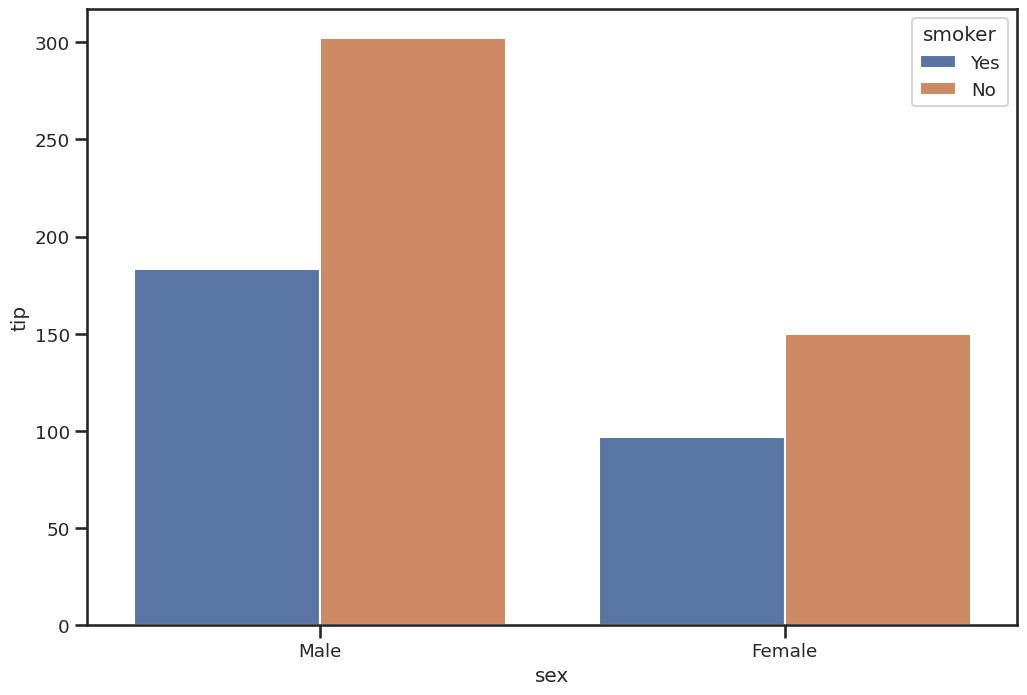

In [27]:

sns.barplot(data=df, x='sex', y='tip', hue='smoker', estimator=np.sum, errorbar=('ci', False))
plt.show()

px.bar(data_frame=df,x='sex',y='tip', color='smoker', barmode='group')


## Pivot Table

In [28]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [31]:
# pivot: sex - day - tip

df.pivot_table(index='sex', columns='day', values='tip')

day,Thur,Fri,Sat,Sun
sex,,,,
Male,2.980333,2.693000,3.083898,3.220345
Female,2.575625,2.781111,2.801786,3.367222


In [36]:
# groupby para comparação
df.groupby(['sex', 'day'])[['tip']].mean()

tip
sex    day           
Male   Thur  2.980333
       Fri   2.693000
       Sat   3.083898
       Sun   3.220345
Female Thur  2.575625
       Fri   2.781111
       Sat   2.801786
       Sun   3.367222

In [39]:
# pivot: sex - time - total_bill/tip
df.pivot_table(index='sex', columns='time', values=['total_bill', 'tip'], aggfunc='sum')

tip         total_bill         
time    Lunch  Dinner      Lunch   Dinner
sex                                      
Male    95.11  389.96     595.60  2661.22
Female  90.40  156.11     571.87   999.08

In [42]:
# pivot: sex - time/day - total_bill/tip
df.pivot_table(index='sex', columns=['time', 'day'], values=['total_bill','tip'], aggfunc=np.median)

tip                                 total_bill                       \
time   Lunch       Dinner                         Lunch        Dinner          
day     Thur   Fri   Thur  Fri    Sat    Sun       Thur    Fri   Thur    Fri   
sex                                                                            
Male    2.53  1.92    NaN  3.0  3.000  3.085     16.975  12.16    NaN  22.49   
Female  2.00  2.75    3.0  3.0  2.625  3.500     13.420  14.70  18.78  15.38   

                       
time                   
day       Sat     Sun  
sex                    
Male    18.24  20.725  
Female  18.36  17.410

In [48]:
# groupby para comparação

df.groupby(['sex', 'time', 'day'])[['total_bill', 'tip']].median()

total_bill    tip
sex    time   day                    
Male   Lunch  Thur      16.975  2.530
              Fri       12.160  1.920
              Sat          NaN    NaN
              Sun          NaN    NaN
       Dinner Thur         NaN    NaN
              Fri       22.490  3.000
              Sat       18.240  3.000
              Sun       20.725  3.085
Female Lunch  Thur      13.420  2.000
              Fri       14.700  2.750
              Sat          NaN    NaN
              Sun          NaN    NaN
       Dinner Thur      18.780  3.000
              Fri       15.380  3.000
              Sat       18.360  2.625
              Sun       17.410  3.500

In [49]:
# pivot com múltiplas funções de agregação

df.pivot_table(index='sex', columns='time', values='tip', aggfunc=['mean', np.median, np.std, lambda x: x.sum()])

mean           median              std           <lambda>        
time       Lunch    Dinner  Lunch Dinner     Lunch    Dinner    Lunch  Dinner
sex                                                                          
Male    2.882121  3.144839   2.31    3.0  1.329017  1.529116    95.11  389.96
Female  2.582857  3.002115   2.01    3.0  1.075108  1.193483    90.40  156.11

In [51]:
# pivot especificando funções em dicionários

agg_dict = {'tip': 'mean', 'total_bill': [np.median, 'min']}
df.pivot_table (index='sex', columns='time', aggfunc=agg_dict)

tip           total_bill                    
            mean               median          min       
time       Lunch    Dinner      Lunch Dinner Lunch Dinner
sex                                                      
Male    2.882121  3.144839      16.58  19.63  7.51   7.25
Female  2.582857  3.002115      13.42  17.19  8.35   3.07

Tabelas no formato Long e Wide

In [52]:
df.groupby(['day','time'])['tip'].mean()

day   time  
Thur  Lunch     2.767705
      Dinner    3.000000
Fri   Lunch     2.382857
      Dinner    2.940000
Sat   Lunch          NaN
      Dinner    2.993103
Sun   Lunch          NaN
      Dinner    3.255132
Name: tip, dtype: float64

In [53]:
df.pivot_table(index='time', columns='day', values='tip')

day,Thur,Fri,Sat,Sun
time,,,,
Lunch,2.767705,2.382857,NaN,NaN
Dinner,3.000000,2.940000,2.993103,3.255132


In [58]:
# Selecionando as colunas day,time e tip, a tabela pode ser considerada wide, pois os elementos não se repetem:
df_pivot = df.pivot_table(index='day', columns='time', values='tip').reset_index()
df_pivot

time,day,Lunch,Dinner
0,Thur,2.767705,3.000000
1,Fri,2.382857,2.940000
2,Sat,NaN,2.993103
3,Sun,NaN,3.255132


In [56]:
# Usando pivot_table, a tabela ficaria no formato wide, pois os elementos se repetem
df_pivot.melt(id_vars='day')


,day,time,value
0,Thur,Lunch,2.767705
1,Fri,Lunch,2.382857
2,Sat,Lunch,NaN
3,Sun,Lunch,NaN
4,Thur,Dinner,3.000000
5,Fri,Dinner,2.940000
6,Sat,Dinner,2.993103
7,Sun,Dinner,3.255132


In [60]:
# Para transformar em long novamente, utilizamos a função `melt` e podemos plotar utilizando seaborn/plotly
df_pivot.melt(id_vars='day')\
.plot.bar(backend='plotly', x='day', y='value', color='time', barmode='group')